In [34]:
import os
import cv2
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, silhouette_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, data_directory, image_size=(256, 256)):
        self.data_directory = data_directory
        self.image_size = image_size
        
    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None, y=None):
        images = []
        labels = []
        # get image labels from the folder names
        class_labels = os.listdir(self.data_directory)
        class_labels.sort()
        # loop through the directory
        for label_idx, class_name in enumerate(class_labels):
            class_dir = os.path.join(self.data_directory, class_name)
            # wrong directory
            if not os.path.isdir(class_dir): 
                continue
            # loop through image files
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                # check for valid image to load
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    img = cv2.imread(file_path)
                    img_resized = cv2.resize(img, self.image_size)
                    if img is not None:
                        images.append(img_resized)  # Store the raw image
                        labels.append(label_idx)  # Store the label as index

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

In [3]:
class ImageTransform(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(128, 128), to_gray=True, normalize=True):
        self.image_size = image_size
        self.to_gray = to_gray
        self.normalize = normalize

    def set_params(self, **params):
        if 'image_size' in params:
            self.image_size = params['image_size']
        if 'to_gray' in params:
            self.to_gray = params['to_gray']
        if 'normalize' in params:
            self.normalize = params['normalize']
        return self

    def fit(self, X=None, y=None):
        return self

    def transform(self, X):
        transformed_images = []
        # preprocess
        for img in X:
            # resize
            if self.image_size:
                img = cv2.resize(img, self.image_size)
            # grayscale
            if self.to_gray:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # normalize
            if self.normalize:
                img = img / 255.0  # Normalize to [0,1]
            transformed_images.append(img)
        
        return np.array(transformed_images)

In [47]:
class SIFTFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=500, to_pipeline = True):
        # use opencv SIFT
        self.sift = cv2.SIFT_create()
        self.max_features = max_features
        self.to_pipeline = to_pipeline

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sift_features = []
        sift_keypoints = []
        for img in X:
            # SIFT takes in uint8 format images
            img_uint8 = (img * 255).astype(np.uint8)
            kp, des = self.sift.detectAndCompute(img_uint8, None)
            # features found
            if des is not None:
                des_flattened = des.flatten()
                # descriptors exceed max features truncate
                if len(des_flattened) > self.max_features:
                    des_flattened = des_flattened[:self.max_features]
                # descriptors shorter pad to max features
                else: 
                    des_flattened = np.pad(des_flattened, (0, self.max_features - len(des_flattened)), 'constant')
            # no features found
            else:
                des_flattened = np.zeros(self.max_features)
            sift_features.append(des_flattened)
            sift_keypoints.append(kp)
        
        if self.to_pipeline: 
            return np.array(sift_features)
        else: 
            return np.array(sift_features), sift_keypoints

In [49]:
class FourierFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, to_pipeline = True):
        self.to_pipeline = to_pipeline
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        fft_features = []
        for img in X:
            # fft
            f_transform = np.fft.fft2(img)
            # shift zero frequency to center
            f_shift = np.fft.fftshift(f_transform)
            magnitude_spectrum = 20 * np.log(np.abs(f_shift))
            if self.to_pipeline: 
                fft_features.append(magnitude_spectrum.flatten())
            else: 
                fft_features.append(magnitude_spectrum)
        return np.array(fft_features)

In [6]:
class SVDReducer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=100):
        self.n_components = n_components
        self.svd = None

    def fit(self, X, y=None):
        n_components = min(self.n_components, X.shape[1]) # debug for actual reduction
        self.svd = TruncatedSVD(n_components=n_components)
        self.svd.fit(X)
        return self

    def transform(self, X):
        return self.svd.transform(X)

In [7]:
# set variable
data_directory = 'data/BigCats'
RANDOM_SEED = 192
# kNN neighbors
number_neighbor = 5
# SVD components
n_components = 200
k_fold = 5

In [42]:
# data load and split
image_loader = ImageLoader(data_directory=data_directory)
images, labels = image_loader.fit_transform(None)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_SEED)

/Users/ygao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ygao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ygao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


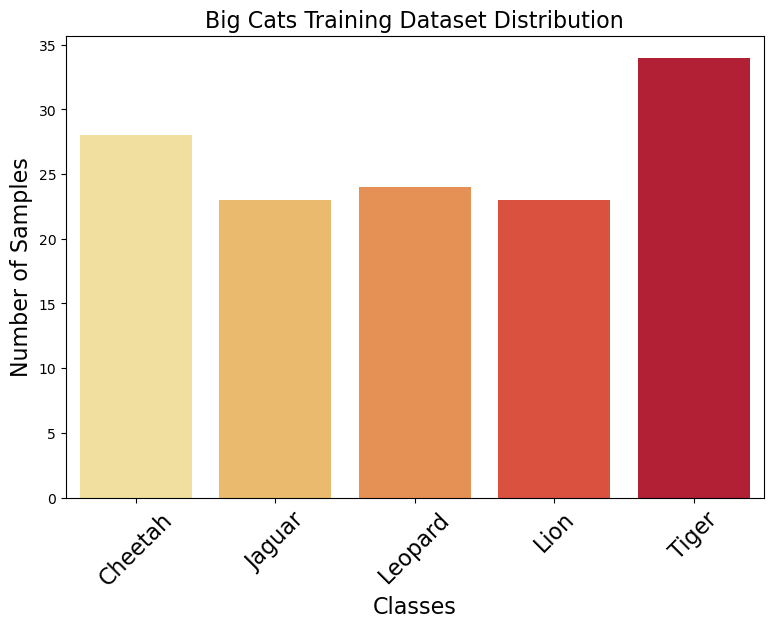

In [40]:
class_names = {0: 'Cheetah', 1: 'Jaguar', 2: 'Leopard', 3: 'Lion', 4: 'Tiger'}
plt.figure(figsize=(9, 6))
sns.countplot(x=y_train, palette='YlOrRd')
plt.xticks(ticks=np.arange(5), labels=[class_names[i] for i in range(5)], rotation=45)
plt.title('Big Cats Training Dataset Distribution', fontsize=16)
plt.xlabel('Classes', fontsize=16)
plt.ylabel('Number of Samples', fontsize=16)
plt.xticks(rotation=45, fontsize=16)  # Rotate labels if they overlap
plt.savefig("figures/dataset_distribution.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

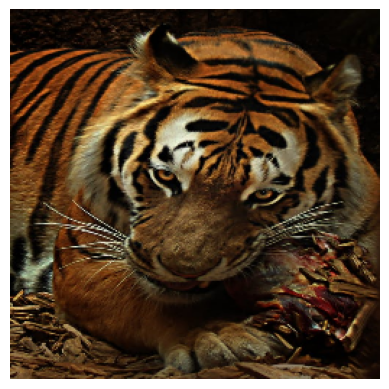

In [14]:
example = cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB)
plt.imshow(example)
plt.axis('off')
plt.savefig("figures/load_example.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

[[0.03137255 0.03921569 0.03921569 ... 0.03921569 0.03921569 0.03529412]
 [0.04313725 0.05490196 0.0627451  ... 0.03137255 0.03137255 0.03137255]
 [0.06666667 0.04313725 0.03529412 ... 0.02745098 0.02745098 0.03137255]
 ...
 [0.42352941 0.44705882 0.34509804 ... 0.05490196 0.04705882 0.04313725]
 [0.25098039 0.10196078 0.25882353 ... 0.04705882 0.04313725 0.04313725]
 [0.20784314 0.2745098  0.34901961 ... 0.05098039 0.04313725 0.03529412]]


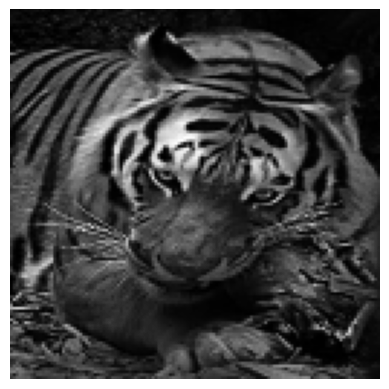

In [19]:
image_tranformer = ImageTransform()
X_train_transform = image_tranformer.fit_transform(X_train)
print(X_train_transform[0])
example_transform = X_train_transform[0]
plt.imshow(example_transform, cmap="gray")
plt.axis('off')
plt.savefig("figures/transform_example.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

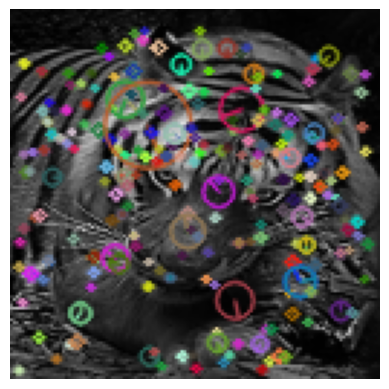

In [30]:
image_sift = SIFTFeatureExtractor(to_pipeline=False)
X_train_sift, X_train_keypoints = image_sift.fit_transform(X_train_transform)

example_sift = X_train_sift[0]
example_keypoints = X_train_keypoints[0]
image_with_keypoints = cv2.drawKeypoints(
    (example_transform * 255).astype(np.uint8), 
    example_keypoints, 
    None, 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.imshow(image_with_keypoints, cmap="gray")
plt.axis('off')
plt.savefig("figures/sift_example.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

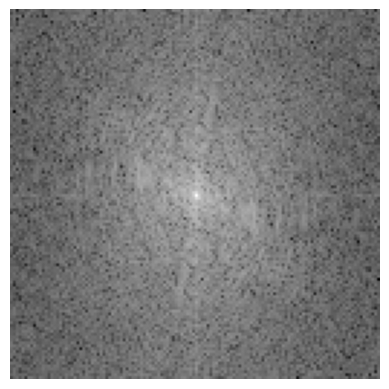

In [33]:
image_fourier = FourierFeatureExtractor(to_pipeline=False)
X_train_fourier = image_fourier.fit_transform(X_train_transform)

example_fourier = X_train_fourier[0]

plt.imshow(example_fourier, cmap="gray")
plt.axis('off')
plt.savefig("figures/fourier_example.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [57]:
# baseline to show number of features vs. F1 score 
# baseline pipeline

sift_knn_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('sift', SIFTFeatureExtractor(to_pipeline=True)),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', KNeighborsClassifier(n_neighbors=number_neighbor))
])
fourier_knn_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', KNeighborsClassifier(n_neighbors=number_neighbor))
])

sift_decision_tree_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))
])
sift_naive_bayes_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', GaussianNB())
])
fourier_decision_tree_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))
])

fourier_naive_bayes_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', GaussianNB())
])
# SVD components
n_components_list = [50, 100, 150, 200, 250]
f1_scores_sift_knn = []
f1_scores_fourier_knn = []
f1_scores_sift_dt = []
f1_scores_sift_nb = []
f1_scores_fourier_dt = []
f1_scores_fourier_nb = []

for n_components in n_components_list:
    # Update SVD component in each pipeline
    sift_knn_pipeline.set_params(svd__n_components=n_components)
    fourier_knn_pipeline.set_params(svd__n_components=n_components)
    sift_decision_tree_pipeline.set_params(svd__n_components=n_components)
    sift_naive_bayes_pipeline.set_params(svd__n_components=n_components)
    fourier_decision_tree_pipeline.set_params(svd__n_components=n_components)
    fourier_naive_bayes_pipeline.set_params(svd__n_components=n_components)
    
    # sift knn
    sift_knn_pipeline.fit(X_train, y_train)
    y_pred_sift = sift_knn_pipeline.predict(X_test)
    f1_sift_knn = f1_score(y_test, y_pred_sift, average='weighted')
    f1_scores_sift_knn.append(f1_sift_knn)
    
    # fourier knn
    fourier_knn_pipeline.fit(X_train, y_train)
    y_pred_fourier = fourier_knn_pipeline.predict(X_test)
    f1_fourier_knn = f1_score(y_test, y_pred_fourier, average='weighted')
    f1_scores_fourier_knn.append(f1_fourier_knn)
    
    # sift dt
    sift_decision_tree_pipeline.fit(X_train, y_train)
    y_pred_sift = sift_decision_tree_pipeline.predict(X_test)
    f1_sift_dt = f1_score(y_test, y_pred_sift, average='weighted')
    f1_scores_sift_dt.append(f1_sift_dt)
    
    # sift nb
    sift_naive_bayes_pipeline.fit(X_train, y_train)
    y_pred_sift = sift_naive_bayes_pipeline.predict(X_test)
    f1_sift_nb = f1_score(y_test, y_pred_sift, average='weighted')
    f1_scores_sift_nb.append(f1_sift_nb)
    
    # fourier dt
    fourier_decision_tree_pipeline.fit(X_train, y_train)
    y_pred_fourier = fourier_decision_tree_pipeline.predict(X_test)
    f1_fourier_dt = f1_score(y_test, y_pred_fourier, average='weighted')
    f1_scores_fourier_dt.append(f1_fourier_dt)
    
    # fourier nb
    fourier_naive_bayes_pipeline.fit(X_train, y_train)
    y_pred_fourier = fourier_naive_bayes_pipeline.predict(X_test)
    f1_fourier_nb = f1_score(y_test, y_pred_fourier, average='weighted')
    f1_scores_fourier_nb.append(f1_fourier_nb)


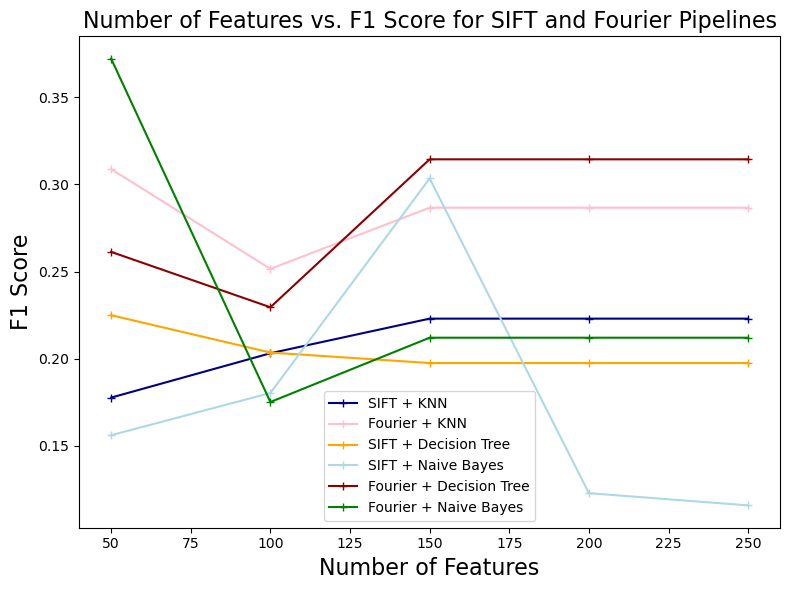

In [60]:
# plot
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, f1_scores_sift_knn, marker='+', color='navy', label='SIFT + KNN')
plt.plot(n_components_list, f1_scores_fourier_knn, marker='+', color='pink', label='Fourier + KNN')
plt.plot(n_components_list, f1_scores_sift_dt, marker='+', color='orange', label='SIFT + Decision Tree')
plt.plot(n_components_list, f1_scores_sift_nb, marker='+', color='lightblue', label='SIFT + Naive Bayes')
plt.plot(n_components_list, f1_scores_fourier_dt, marker='+', color='darkred', label='Fourier + Decision Tree')
plt.plot(n_components_list, f1_scores_fourier_nb, marker='+', color='green', label='Fourier + Naive Bayes')

plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("F1 Score", fontsize=16)
plt.title("Number of Features vs. F1 Score for SIFT and Fourier Pipelines", fontsize=16)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("figures/features_f1scores.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()